# AUPIMO statistical comparison between two models

Say, model A has a higher average AUPIMO than model B. 

Can you be _sure_ that A is better than B? 

We'll use statistical tests here to make informed decisions about this.

> For basic usage, please check the notebook [701a_aupimo.ipynb](./701a_aupimo.ipynb).
>
> For fetching AUPIMO results from the paper's benchmark, please check the notebook [701e_aupimo_advanced_iv.ipynb](./701e_aupimo_advanced_iv.ipynb).


# What is AUPIMO?

The `Area Under the Per-Image Overlap [curve]` (AUPIMO) is a metric of recall (higher is better) designed for visual anomaly detection.

Inspired by the [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and [PRO](https://link.springer.com/article/10.1007/s11263-020-01400-4) curves, 

> AUPIMO is the area under a curve of True Positive Rate (TPR or _recall_) as a function of False Positive Rate (FPR) restricted to a fixed range. 

But:
- the TPR (Y-axis) is *per-image* (1 image = 1 curve/score);
- the FPR (X-axis) considers the (average of) **normal** images only; 
- the FPR (X-axis) is in log scale and its range is [1e-5, 1e-4]\* (harder detection task!).

\* The score (the area under the curve) is normalized to be in [0, 1].

AUPIMO can be interpreted as

> average segmentation recall in an image given that the model (nearly) does not yield false positives in normal images.

References in the last cell.

![AUROC vs. AUPRO vs. AUPIMO](./roc_pro_pimo.svg)

# Setup

Install `anomalib` using `pip`.

In [1]:
# TODO(jpcbertoldo): replace by `pip install anomalib` when AUPIMO is released  # noqa: TD003
# %pip install ../..

Imports

In [2]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, IndexLocator, MaxNLocator, PercentFormatter
from scipy import stats

from anomalib.metrics.pimo import get_aupimo_benchmark

/home/jcasagrandebertoldo/miniconda3/envs/anomalib-dev/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [3]:
pd.options.display.float_format = "{:.3f}".format

In [4]:
%matplotlib inline

# Fetch results from AUPIMO's benchmark

Unlike previous notebook, we will not train and evaluate the models here.

We'll load the AUPIMO scores from the benchmark presented in our paper (check the reference in the last cell).

These scores can be found in AUPIMO's official repository in [`jpcbertoldo:aupimo/data/experiments/benchmark`](https://github.com/jpcbertoldo/aupimo/tree/main/data/experiments/benchmark).

> For details, see the notebook [701e_aupimo_advanced_iv.ipynb](./701e_aupimo_advanced_iv.ipynb).

In [5]:
# this will download the aupimo scores for all models and a single dataset
_, data_per_image = get_aupimo_benchmark(model=None, dataset="mvtec/capsule")
# we'll only use two models
data_per_image = data_per_image.query("model in ['patchcore_wr101', 'patchcore_wr50']")
data_per_image  # noqa: B018, RUF100

,model,dataset,sample_index,aupimo,path
792,patchcore_wr101,mvtec/capsule,0,0.250,MVTec/capsule/test/crack/000.png
793,patchcore_wr101,mvtec/capsule,1,0.996,MVTec/capsule/test/crack/001.png
794,patchcore_wr101,mvtec/capsule,2,0.996,MVTec/capsule/test/crack/002.png
795,patchcore_wr101,mvtec/capsule,3,0.984,MVTec/capsule/test/crack/003.png
796,patchcore_wr101,mvtec/capsule,4,0.996,MVTec/capsule/test/crack/004.png
...,...,...,...,...,...
1051,patchcore_wr50,mvtec/capsule,127,0.933,MVTec/capsule/test/squeeze/015.png
1052,patchcore_wr50,mvtec/capsule,128,0.984,MVTec/capsule/test/squeeze/016.png
1053,patchcore_wr50,mvtec/capsule,129,0.933,MVTec/capsule/test/squeeze/017.png
1054,patchcore_wr50,mvtec/capsule,130,0.964,MVTec/capsule/test/squeeze/018.png


We'll remove the `nan` values from the normal images.

In [6]:
# extract the labels (i.e. anomaly type or 'good')
# from the paths where the AUPIMO scores were computed from
data_per_image["label"] = data_per_image["path"].map(lambda path: path.split("/")[-2])

# let's extract only the AUPIMO scores from anomalies
modela = data_per_image.query("model == 'patchcore_wr50' and label != 'good'")["aupimo"].to_numpy()
modelb = data_per_image.query("model == 'patchcore_wr101' and label != 'good'")["aupimo"].to_numpy()
labels = data_per_image.query("model == 'patchcore_wr50' and label != 'good'")["label"].to_numpy()
print(f"{modela.shape=} {modelb.shape=} {labels.shape=}")

modela.shape=(109,) modelb.shape=(109,) labels.shape=(109,)


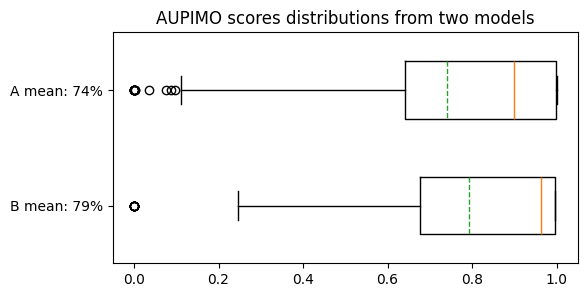

In [7]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.boxplot(
    [modela, modelb],
    tick_labels=[f"A mean: {modela.mean():.0%}", f"B mean: {modelb.mean():.0%}"],
    vert=False,
    showmeans=True,
    meanline=True,
    widths=0.5,
)
ax.invert_yaxis()
ax.set_title("AUPIMO scores distributions from two models")
fig  # noqa: B018, RUF100

Is this difference significant?

# Image by image comparison

Since we have the scores of each model for each image, we can compare them image by image.

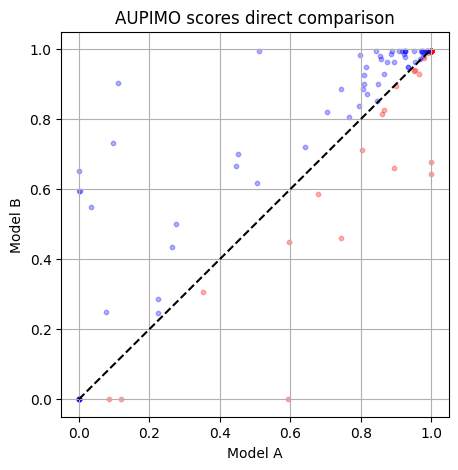

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
modela_is_better = modela > modelb
ax.scatter(modela[modela_is_better], modelb[modela_is_better], alpha=0.3, s=10, color="red", marker="o")
ax.scatter(modela[~modela_is_better], modelb[~modela_is_better], alpha=0.3, s=10, color="blue", marker="o")
ax.plot([0, 1], [0, 1], color="black", linestyle="--")
ax.set_xlabel("Model A")
ax.set_ylabel("Model B")
ax.set_title("AUPIMO scores direct comparison")
ax.grid()
fig  # noqa: B018, RUF100

The dashed line is where both models have the same AUPIMO score.

Notice that there are images where one performs better than the other and vice-versa.

# Parametric Comparison

Before using the statistical test, let's first visualize the data seen by the test.

We'll use a _paired_ t-test, which means we'll compare the AUPIMO scores of the same image one by one.

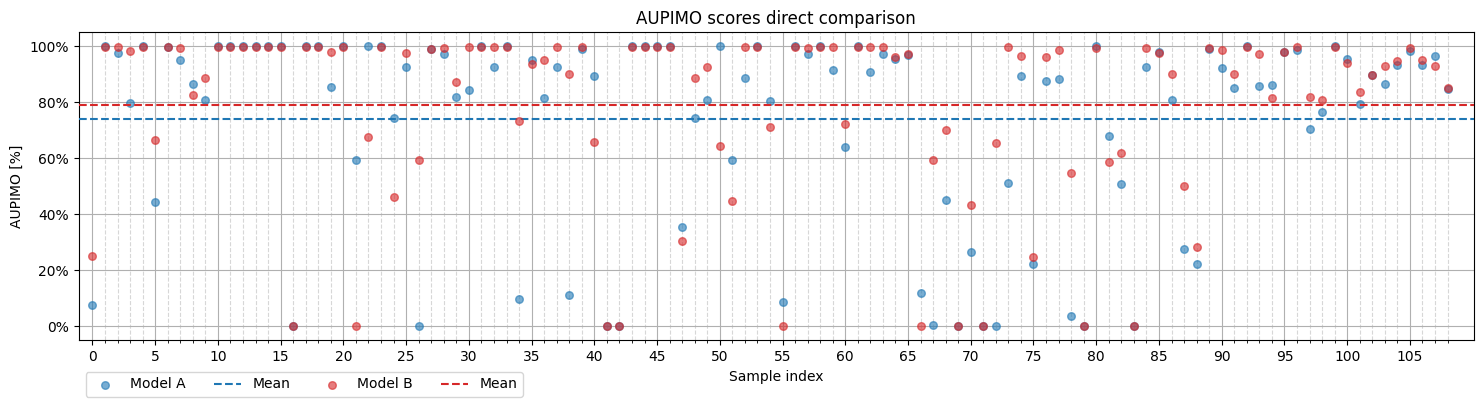

In [9]:
num_samples = modela.shape[0]
indexes = np.arange(num_samples)

fig, ax = plt.subplots(figsize=(18, 4))

# plot sample index vs score and their mean
ax.scatter(indexes, modela, s=30, color="tab:blue", marker="o", label="Model A", zorder=3, alpha=0.6)
ax.axhline(modela.mean(), color="tab:blue", linestyle="--", label="Mean", zorder=3)
ax.scatter(indexes, modelb, s=30, color="tab:red", marker="o", label="Model B", zorder=3, alpha=0.6)
ax.axhline(modelb.mean(), color="tab:red", linestyle="--", label="Mean", zorder=3)

# configure the x-axis
ax.set_xlabel("Sample index")
ax.set_xlim(0 - (eps := 0.01 * num_samples), num_samples + eps)
ax.xaxis.set_major_locator(IndexLocator(5, 0))
ax.xaxis.set_minor_locator(IndexLocator(1, 0))

# configure the y-axis
ax.set_ylabel("AUPIMO [%]")
ax.set_ylim(0 - 0.05, 1 + 0.05)
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_formatter(PercentFormatter(1))

# configure the grid, legend, etc
ax.grid(axis="both", which="major", linestyle="-")
ax.grid(axis="x", which="minor", linestyle="--", alpha=0.5)
ax.legend(ncol=4, loc="upper left", bbox_to_anchor=(0, -0.08))
ax.set_title("AUPIMO scores direct comparison")

fig  # noqa: B018, RUF100

Notice that several images actually have the same AUPIMO score for both models (e.g. from 10 to 15).

Others like 21 show a big difference -- model B didn't detect the anomaly at all, but model A did a good job (60% AUPIMO).

Let's simplify this and only show the differences.

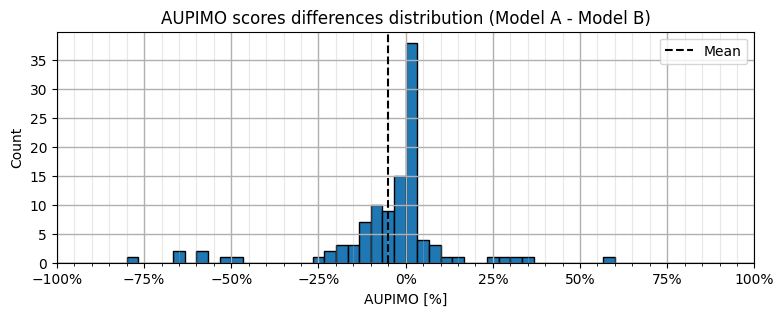

In [10]:
differences = modela - modelb

fig, ax = plt.subplots(figsize=(9, 3))
ax.hist(differences, bins=np.linspace(-1, 1, 61), edgecolor="black")
ax.axvline(differences.mean(), color="black", linestyle="--", label="Mean")

# configure the x-axis
ax.set_xlabel("AUPIMO [%]")
ax.set_xlim(-1, 1)
ax.xaxis.set_major_locator(MaxNLocator(9))
ax.xaxis.set_minor_locator(MaxNLocator(41))
ax.xaxis.set_major_formatter(PercentFormatter(1))

# configure the y-axis
ax.set_ylabel("Count")

# configure the grid, legend, etc
ax.grid(axis="both", which="major", linestyle="-", alpha=1, linewidth=1.0)
ax.grid(axis="x", which="minor", linestyle="-", alpha=0.3)
ax.legend(loc="upper right")
ax.set_title("AUPIMO scores differences distribution (Model A - Model B)")

fig  # noqa: B018, RUF100

It looks like there is a bias to the right indeed (so model A > model B). 

Is that statistically significant or just random?

> **Dependent t-test for paired samples**
> 
> - null hypothesis: `average(A) == average(B)` 
> - alternative hypothesis: `average(A) != average(B)`
> 
> See [`scipy.stats.ttest_rel`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) and [" Wikipedia's page on "Student's t-test"](https://en.wikipedia.org/wiki/Student's_t-test#Dependent_t-test_for_paired_samples).
>
> **Confidence Level**
> 
> Instead of reporting the p-value, we'll report the "confidence level" [that the null hypothesis is false], which is `1 - pvalue`.
>  
> *Higher* confidence level *more confident* that `average(A) > average(B)`.

In [11]:
test_result = stats.ttest_rel(modela, modelb)
confidence = 1.0 - float(test_result.pvalue)
print(f"{test_result=}")
print(f"{confidence=:.1%}")

test_result=TtestResult(statistic=-2.8715471705520033, pvalue=0.004917091449731462, df=108)
confidence=99.5%


So, we're very confident that model A has a higher AUPIMO score than model B.

Maybe is that due to some big differences in a few images?

What if we don't count much for these big differences?

# Non-parametric (rank comparison)

In non-parametric comparison, bigger differences don't matter more than smaller differences. 

It's all about their relative position.

Let's look at the analogous plots for this type of comparison.

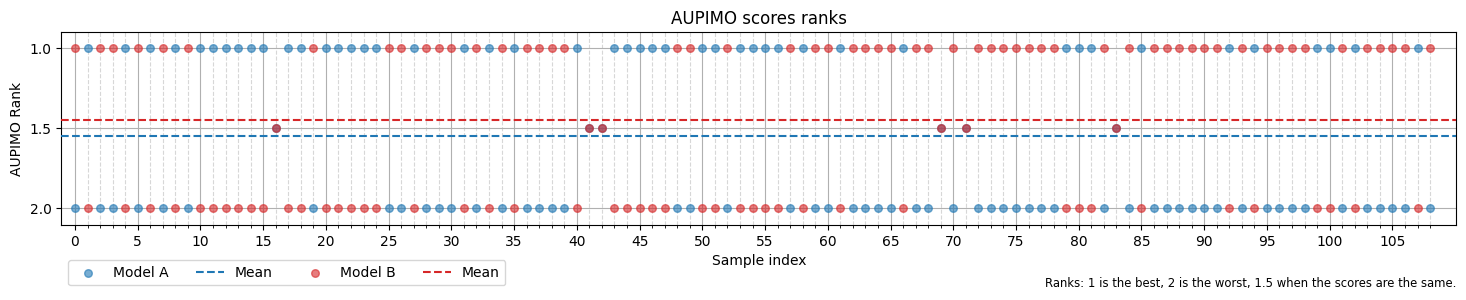

In [12]:
# the `-` sign is to sort in descending order because higher AUPIMO is better
# the rank values are 1 or 2 because there are only two models
# where 1 is the best and 2 is the worst
# when the scores are the same, 1.5 is assigned to both models
ranks = stats.rankdata(-np.stack([modela, modelb], axis=1), method="average", axis=1)
ranksa, ranksb = ranks[:, 0], ranks[:, 1]

num_samples = ranks.shape[0]
indexes = np.arange(num_samples)

fig, ax = plt.subplots(figsize=(18, 2.5))

# plot sample index vs score and their mean
ax.scatter(indexes, ranksa, s=30, color="tab:blue", marker="o", label="Model A", zorder=3, alpha=0.6)
ax.axhline(ranksa.mean(), color="tab:blue", linestyle="--", label="Mean", zorder=3)
ax.scatter(indexes, ranksb, s=30, color="tab:red", marker="o", label="Model B", zorder=3, alpha=0.6)
ax.axhline(ranksb.mean(), color="tab:red", linestyle="--", label="Mean", zorder=3)

# configure the x-axis
ax.set_xlabel("Sample index")
ax.set_xlim(0 - (eps := 0.01 * num_samples), num_samples + eps)
ax.xaxis.set_major_locator(IndexLocator(5, 0))
ax.xaxis.set_minor_locator(IndexLocator(1, 0))

# configure the y-axis
ax.set_ylabel("AUPIMO Rank")
ax.set_ylim(1 - 0.1, 2 + 0.1)
ax.yaxis.set_major_locator(FixedLocator([1, 1.5, 2]))
ax.invert_yaxis()

# configure the grid, legend, etc
ax.grid(axis="both", which="major", linestyle="-")
ax.grid(axis="x", which="minor", linestyle="--", alpha=0.5)
ax.legend(ncol=4, loc="upper left", bbox_to_anchor=(0, -0.15))
ax.set_title("AUPIMO scores ranks")

fig.text(
    0.9,
    -0.1,
    "Ranks: 1 is the best, 2 is the worst, 1.5 when the scores are the same.",
    ha="right",
    va="top",
    fontsize="small",
)

fig  # noqa: B018, RUF100

Again, blue seems to have a slight advantage, but -- again -- is it significant enough to be sure that model A is better than model B?

Remember that AUPIMO is a recall metric, so it is basically a ratio of the area of anomalies. 

Is it relevant if model A has 1% more recall than model B in a given image?

> You can check that out in [`701b_aupimo_advanced_i.ipybn`](./701b_aupimo_advanced_i.ipynb).

We'll --arbitrarily -- assume that only differences above 5% are relevant.

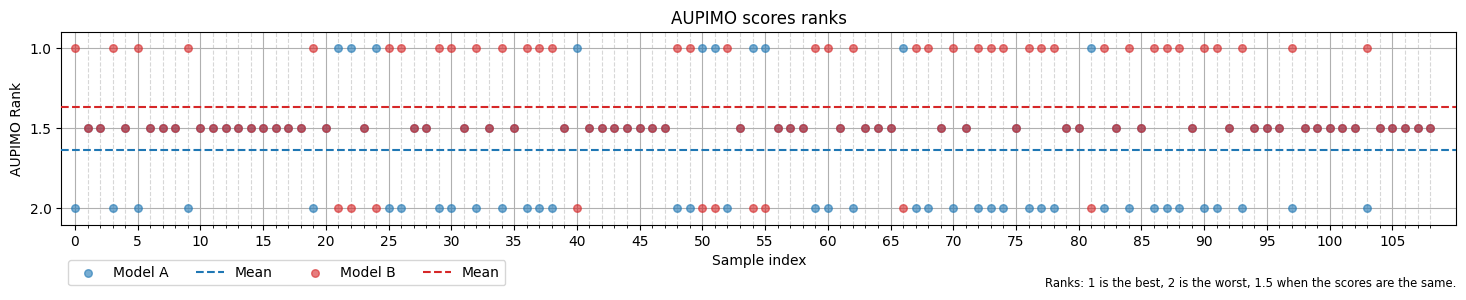

In [13]:
MIN_ABS_DIFF = 0.05
scores = np.stack([modela, modelb], axis=1)
ranks = stats.rankdata(-scores, method="average", axis=1)
abs_diff = np.abs(np.diff(scores, axis=1)).flatten()
ranks[abs_diff < MIN_ABS_DIFF, :] = 1.5
ranksa, ranksb = ranks[:, 0], ranks[:, 1]

num_samples = ranks.shape[0]
indexes = np.arange(num_samples)

fig, ax = plt.subplots(figsize=(18, 2.5))

# plot sample index vs score and their mean
ax.scatter(indexes, ranksa, s=30, color="tab:blue", marker="o", label="Model A", zorder=3, alpha=0.6)
ax.axhline(ranksa.mean(), color="tab:blue", linestyle="--", label="Mean", zorder=3)
ax.scatter(indexes, ranksb, s=30, color="tab:red", marker="o", label="Model B", zorder=3, alpha=0.6)
ax.axhline(ranksb.mean(), color="tab:red", linestyle="--", label="Mean", zorder=3)

# configure the x-axis
ax.set_xlabel("Sample index")
ax.set_xlim(0 - (eps := 0.01 * num_samples), num_samples + eps)
ax.xaxis.set_major_locator(IndexLocator(5, 0))
ax.xaxis.set_minor_locator(IndexLocator(1, 0))

# configure the y-axis
ax.set_ylabel("AUPIMO Rank")
ax.set_ylim(1 - 0.1, 2 + 0.1)
ax.yaxis.set_major_locator(FixedLocator([1, 1.5, 2]))
ax.invert_yaxis()

# configure the grid, legend, etc
ax.grid(axis="both", which="major", linestyle="-")
ax.grid(axis="x", which="minor", linestyle="--", alpha=0.5)
ax.legend(ncol=4, loc="upper left", bbox_to_anchor=(0, -0.15))
ax.set_title("AUPIMO scores ranks")

fig.text(
    0.9,
    -0.1,
    "Ranks: 1 is the best, 2 is the worst, 1.5 when the scores are the same.",
    ha="right",
    va="top",
    fontsize="small",
)

fig  # noqa: B018, RUF100

The advantage of A over B is clearer now.

Most of cases where B was better were within the difference margin of 5%.

The average ranks also got more distant.

Could it be by chance or can we be confident that model A is better than model B?

> **Wilcoxon signed rank test**
> 
> - null hypothesis: `average(rankA) == average(rankB)` 
> - alternative hypothesis: `average(rankA) != average(rankB)`
> 
> See [`scipy.stats.wilcoxon`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon) and ["Wilcoxon signed-rank test" in Wikipedia](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test).
>
> Confidence Level (reminder): *higher* confidence level *more confident* that `average(rankA) > average(rankB)`.


In [14]:
stats.wilcoxon(differences, zero_method="zsplit")

WilcoxonResult(statistic=1965.5, pvalue=0.001788856917447151)

In [15]:
MIN_ABS_DIFF = 0.05
differences = modela - modelb
differences[abs_diff < MIN_ABS_DIFF] = 0.0
test_result = stats.wilcoxon(differences, zero_method="zsplit")
confidence = 1.0 - float(test_result.pvalue)
print(f"{test_result=}")
print(f"{confidence=:.1%}")

test_result=WilcoxonResult(statistic=1823.0, pvalue=0.0002876893285960681)
confidence=100.0%


We got such a high confidence that we can say for sure that these differences are not due to chance.

So we can say that model A is _consistently_ better than model B -- even though some counter examples exist as we saw in the image by image comparison.

# Cite Us

AUPIMO was developed during [Google Summer of Code 2023 (GSoC 2023)](https://summerofcode.withgoogle.com/archive/2023/projects/SPMopugd) with the `anomalib` team from Intel's OpenVINO Toolkit.

arXiv: [arxiv.org/abs/2401.01984](https://arxiv.org/abs/2401.01984) (accepted to BMVC 2024)

Official repository: [github.com/jpcbertoldo/aupimo](https://github.com/jpcbertoldo/aupimo) (numpy-only API and numba-accelerated versions available)

```bibtex
@misc{bertoldo2024aupimo,
      author={Joao P. C. Bertoldo and Dick Ameln and Ashwin Vaidya and Samet Akçay},
      title={{AUPIMO: Redefining Visual Anomaly Detection Benchmarks with High Speed and Low Tolerance}}, 
      year={2024},
      url={https://arxiv.org/abs/2401.01984}, 
}
```

---

# Utils: pairwise statistical tests with multiple models

What if you have multiple models to compare?

Here we define a functions that will return all the pairwise comparisons between the models.

In [16]:
import itertools
from typing import Any, Literal

import numpy as np
from numpy import ndarray
from scipy import stats
from torch import Tensor


def _validate_models(models: dict[str, Tensor | ndarray]) -> dict[str, ndarray]:
    """Make sure the input `models` is valid and convert all the dict's values to `ndarray`.

    Args:
        models (dict[str, Tensor | ndarray]): {"model name": sequence of shape (num_images,)}.
    Validations:
        - keys are strings (model names)
        - there are at least two models
        - values are sequences of floats in [0, 1] or `nan`
        - all sequences have the same shape
        - all `nan` values are at the positions
    Returns:
        dict[str, ndarray]: {"model name": array (num_images,)}.
    """
    if not isinstance(models, dict):
        msg = f"Expected argument `models` to be a dict, but got {type(models)}."
        raise TypeError(msg)

    if len(models) < 2:
        msg = "Expected argument `models` to have at least one key, but got none."
        raise ValueError(msg)

    ref_num_samples = None
    ref_nans = None
    for key in models:
        if not isinstance(key, str):
            msg = f"Expected argument `models` to have all keys of type str. Found {type(key)}."
            raise TypeError(msg)

        value = models[key]

        if not isinstance(value, Tensor | ndarray):
            msg = (
                "Expected argument `models` to have all values of type Tensor or ndarray. "
                f"Found {type(value)} on {key=}."
            )
            raise TypeError(msg)

        if isinstance(value, Tensor):
            models[key] = value = value.numpy()

        if not np.issubdtype(value.dtype, np.floating):
            msg = f"Expected argument `models` to have all values of floating type. Found {value.dtype} on {key=}."
            raise ValueError(msg)

        if value.ndim != 1:
            msg = f"Expected argument `models` to have all values of 1D arrays. Found {value.ndim} on {key=}."
            raise ValueError(msg)

        if ref_num_samples is None:
            ref_num_samples = num_samples = value.shape[0]
            ref_nans = nans = np.isnan(value)

        if num_samples != ref_num_samples:
            msg = "Argument `models` has inconsistent number of samples."
            raise ValueError(msg)

        if (nans != ref_nans).any():
            msg = "Argument `models` has inconsistent `nan` values (in different positions)."
            raise ValueError(msg)

        if (value[~nans] < 0).any() or (value[~nans] > 1).any():
            msg = (
                "Expected argument `models` to have all sequences of floats \\in [0, 1]. "
                f"Key {key} has values outside this range."
            )
            raise ValueError(msg)

    return models


def test_pairwise(
    models: dict[str, Tensor | ndarray],
    *,
    test: Literal["ttest_rel", "wilcoxon"],
    min_abs_diff: float | None = None,
) -> list[dict[str, Any]]:
    """Compare all pairs of models using statistical tests.

    Scores are assumed to be *higher is better*.

    General hypothesis in the tests:
        - Null hypothesis: two models are equivalent on average.
        - Alternative hypothesis: one model is better than the other (two-sided test).

    Args:
        models (dict[str, Tensor | ndarray]): {"model name": sequence of shape (num_images,)}.
        test (Literal["ttest_rel", "wilcoxon"]): The statistical test to use.
            - "ttest_rel": Paired Student's t-test (parametric).
            - "wilcoxon": Wilcoxon signed-rank test (non-parametric).
        min_abs_diff (float | None): Minimum absolute difference to consider in the Wilcoxon test. If `None`, all
            differences are considered. Default is `None`. Ignored in the t-test.
    """
    models = _validate_models(models)
    if test not in {"ttest_rel", "wilcoxon"}:
        msg = f"Expected argument `test` to be 'ttest_rel' or 'wilcoxon', but got '{test}'."
        raise ValueError(msg)
    # remove nan values
    models = {k: v[~np.isnan(v)] for k, v in models.items()}
    models_names = sorted(models.keys())
    num_models = len(models)
    comparisons = list(itertools.combinations(range(num_models), 2))

    # for each comparison, compute the test and confidence (1 - p-value)
    test_results = []
    for modela_idx, modelb_idx in comparisons:  # indices of the sorted model names
        modela = models_names[modela_idx]
        modelb = models_names[modelb_idx]
        modela_scores = models[modela]
        modelb_scores = models[modelb]
        if test == "ttest_rel":
            test_result = stats.ttest_rel(modela_scores, modelb_scores, alternative="two-sided")
        else:  # test == "wilcoxon"
            differences = modela_scores - modelb_scores
            if min_abs_diff is not None:
                differences[np.abs(differences) < min_abs_diff] = 0.0
            # extreme case
            if (differences == 0).all():
                test_result = stats._morestats.WilcoxonResult(np.nan, 1.0)  # noqa: SLF001
            else:
                test_result = stats.wilcoxon(differences, zero_method="zsplit", alternative="two-sided")
        test_results.append({
            "modela": modela,
            "modelb": modelb,
            "confidence": 1 - test_result.pvalue,
            "pvalue": test_result.pvalue,
            "statistic": test_result.statistic,
        })

    return test_results

Let's first test it with the same two models we used before.

In [17]:
# parametric test
pd.DataFrame.from_records(test_pairwise({"A": modela, "B": modelb}, test="ttest_rel"))

,modela,modelb,confidence,pvalue,statistic
0,A,B,0.995,0.005,-2.872


In [18]:
# non-parametric test
pd.DataFrame.from_records(test_pairwise({"A": modela, "B": modelb}, test="wilcoxon"))

,modela,modelb,confidence,pvalue,statistic
0,A,B,0.998,0.002,1965.500


In [19]:
# non-parametric test with a minimum absolute difference
pd.DataFrame.from_records(test_pairwise({"A": modela, "B": modelb}, test="wilcoxon", min_abs_diff=0.05))

,modela,modelb,confidence,pvalue,statistic
0,A,B,1.000,0.000,1823.000


Now let's get the best models from the benchmark in our paper and compare them two by two.

We'll look at the dataset `cashew` from `VisA`.

> More details in the paper (see the last cell).

In [20]:
# fetch scores from the benchmark
_, data = get_aupimo_benchmark(model=None, dataset="visa/cashew")

# only select a few models
model_selection = ("efficientad_wr101_s_ext", "patchcore_wr101", "rd++_wr50_ext", "simplenet_wr50_ext", "uflow_ext")
data = data.query("model in @model_selection").reset_index(drop=True)

# this is the format expected by the util function
models = {model: df.to_numpy() for model, df in data.groupby("model", observed=True)["aupimo"]}

pairwise_test_results = test_pairwise(models, test="wilcoxon", min_abs_diff=0.1)
pd.DataFrame.from_records(pairwise_test_results).style.background_gradient(
    cmap="jet",
    vmin=0,
    vmax=1,
    subset=["confidence"],
)

,modela,modelb,confidence,pvalue,statistic
0,efficientad_wr101_s_ext,patchcore_wr101,0.999402,0.000598,1580.000000
1,efficientad_wr101_s_ext,rd++_wr50_ext,0.773659,0.226341,2193.500000
2,efficientad_wr101_s_ext,simplenet_wr50_ext,1.000000,0.000000,690.500000
3,efficientad_wr101_s_ext,uflow_ext,0.999447,0.000553,1550.500000
4,patchcore_wr101,rd++_wr50_ext,0.999980,0.000020,1333.000000
5,patchcore_wr101,simplenet_wr50_ext,1.000000,0.000000,351.500000
6,patchcore_wr101,uflow_ext,0.731875,0.268125,2213.000000
7,rd++_wr50_ext,simplenet_wr50_ext,1.000000,0.000000,967.000000
8,rd++_wr50_ext,uflow_ext,0.999945,0.000055,1383.000000
9,simplenet_wr50_ext,uflow_ext,1.000000,0.000000,318.500000


# Cite Us

AUPIMO was developed during [Google Summer of Code 2023 (GSoC 2023)](https://summerofcode.withgoogle.com/archive/2023/projects/SPMopugd) with the `anomalib` team from Intel's OpenVINO Toolkit.

arXiv: [arxiv.org/abs/2401.01984](https://arxiv.org/abs/2401.01984) (accepted to BMVC 2024)

Official repository: [github.com/jpcbertoldo/aupimo](https://github.com/jpcbertoldo/aupimo) (numpy-only API and numba-accelerated versions available)

```bibtex
@misc{bertoldo2024aupimo,
      author={Joao P. C. Bertoldo and Dick Ameln and Ashwin Vaidya and Samet Akçay},
      title={{AUPIMO: Redefining Visual Anomaly Detection Benchmarks with High Speed and Low Tolerance}}, 
      year={2024},
      url={https://arxiv.org/abs/2401.01984}, 
}
```